# Predicción del precio de casas de Boston

Intentaremos predecir el precio mediano de las viviendas en un barrio de Boston a mediados de la década de 1970, partiendo de una variedad de datos sobre el el barrio en el momento, como la tasa de criminalidad, la tasa de impuesto a la propiedad, etc.

El conjunto de datos que usaremos es pequeña, 506 muestras en total. Debemos estar atentos, ya que hay valores discretos y continuos (como la criminalidad).

Los datos contienen 13 características a partir de las cuales deberíamos ser capaces de poder predecir el precio de cada vivienda. Las características son:

1. Ratio de crimen per cápita.

2. Proporción de tierra residencial dividida en zonas de más de 25.000 pies cuadrados.
3. Proporción de acres de negocios no minoristas por ciudad.
4. Variable ficticia de Charles River (= 1 si limita con el río; 0 en caso contrario).
5. Concentración de óxidos nítricos (partes por 10 millones).
6. Número promedio de habitaciones por vivienda.
7. Proporción de unidades ocupadas por sus propietarios y construídas antes de 1940.
8. Distancias ponderadas a cinco centros de empleo de Boston.
9. Índice de accesibilidad a carreteras radiales.
10. Tasa de impuesto a la propiedad de valor total por $10,000.
11. Relación alumno-profesor por localidad.
12. 1000 * (Bk - 0.63) ** 2 donde Bk es la proporción de personas negras por pueblo.
13. % de población de un estatus bajo.

In [ ]:
! pip install analytics-zoo
! sudo apt install openjdk-8-jdk
! echo "2" | sudo update-alternatives --config java

In [ ]:
from zoo.common.nncontext import *
sc = init_nncontext(init_spark_conf().setMaster("local[4]"))

Prepending /usr/local/lib/python3.6/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.6/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.10.0-spark_2.4.3-0.8.1-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.6/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [ ]:
from zoo.pipeline.api.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

24576/57026 [===========>..................] - ETA: 0sSuccessfully downloaded boston_housing.npz 57026 bytes.


In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

In [ ]:
train_targets

array([22.6, 50. , 23. ,  8.3, 21.2, 19.9, 20.6, 18.7, 16.1, 18.6,  8.8,
       17.2, 14.9, 10.5, 50. , 29. , 23. , 33.3, 29.4, 21. , 23.8, 19.1,
       20.4, 29.1, 19.3, 23.1, 19.6, 19.4, 38.7, 18.7, 14.6, 20. , 20.5,
       20.1, 23.6, 16.8,  5.6, 50. , 14.5, 13.3, 23.9, 20. , 19.8, 13.8,
       16.5, 21.6, 20.3, 17. , 11.8, 27.5, 15.6, 23.1, 24.3, 42.8, 15.6,
       21.7, 17.1, 17.2, 15. , 21.7, 18.6, 21. , 33.1, 31.5, 20.1, 29.8,
       15.2, 15. , 27.5, 22.6, 20. , 21.4, 23.5, 31.2, 23.7,  7.4, 48.3,
       24.4, 22.6, 18.3, 23.3, 17.1, 27.9, 44.8, 50. , 23. , 21.4, 10.2,
       23.3, 23.2, 18.9, 13.4, 21.9, 24.8, 11.9, 24.3, 13.8, 24.7, 14.1,
       18.7, 28.1, 19.8, 26.7, 21.7, 22. , 22.9, 10.4, 21.9, 20.6, 26.4,
       41.3, 17.2, 27.1, 20.4, 16.5, 24.4,  8.4, 23. ,  9.7, 50. , 30.5,
       12.3, 19.4, 21.2, 20.3, 18.8, 33.4, 18.5, 19.6, 33.2, 13.1,  7.5,
       13.6, 17.4,  8.4, 35.4, 24. , 13.4, 26.2,  7.2, 13.1, 24.5, 37.2,
       25. , 24.1, 16.6, 32.9, 36.2, 11. ,  7.2, 22

## Preparamos los datos

Estandarizamos los datos para centrarlos alrededor del 0

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [ ]:
print(train_data)
print(test_data)

[[-0.40241083 -0.48917404 -1.17629455 ... -0.7163786   0.20831263
  -0.75004698]
 [ 0.61863723 -0.48917404  1.04403852 ...  0.82605672  0.1090616
  -0.44090876]
 [-0.39717361 -0.48917404  0.41499396 ... -0.95008092  0.41130618
  -0.30398452]
 ...
 [-0.36395996 -0.48917404 -0.73402093 ... -0.48267628  0.17402392
  -0.8883828 ]
 [-0.15021417 -0.48917404  1.26517533 ... -1.74466881  0.00871508
   2.21146895]
 [ 0.04657554 -0.48917404  1.26517533 ... -1.74466881  0.44592354
   1.94326684]]
[[-0.40573743 -0.48917404 -0.88493186 ...  0.82605672  0.36376209
  -0.83333079]
 [-0.40256235 -0.48917404 -1.29283962 ... -0.29571442  0.43124403
  -0.718992  ]
 [ 0.59085911 -0.48917404  1.04403852 ...  0.82605672  0.23591887
   0.69824442]
 ...
 [-0.39308165 -0.48917404 -0.16474307 ... -0.29571442  0.41974142
  -0.33221632]
 [-0.38435962 -0.48917404 -0.62793503 ... -0.24897396  0.40035132
   0.86763522]
 [-0.3944007  -0.48917404 -1.05526697 ... -0.85659999  0.44592354
   0.28747171]]


**Tengamos en cuenta que las cantidades que usamos para estandarizar los datos de test se han calculado utilizando los datos de entrenamiento. Nunca debemos usar en nuestro
flujo de trabajo cualquier cantidad calculada en los datos de prueba, incluso para algo tan simple como la estandarización de datos.**

## Creamos nuestra red

Debido a que tenemos pocas muestras, usaremos una red pequeña con 2 capas ocultas de 6 neuronas cada una. En general, cuanto menos muestras de entrenamiento se tiene, más fácil es hacer overfitting. Para evitarlo, utilizar una red pequeña suele ser una buena opción.

In [ ]:
from zoo.pipeline.api.keras import models
from zoo.pipeline.api.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Nuestra red termina con una sola unidad y sin activación (es decir, será una capa lineal).
Esta es una configuración típica para la regresión escalar (es decir, regresión en la que estamos tratando de predecir un solo valor continuo). Aplicar una función de activación restringiría el rango que puede tomar la salida; por ejemplo si aplicamos una función de activación sigmoide a nuestra última capa, la red solo podía aprender a predecir valores entre 0 y 1. Aquí, porque la última capa es puramente lineal, la red es libre de aprender a predecir valores en cualquier rango.

Estamos compilando la red con la función de pérdida mse - Error cuadrático medio, el cuadrado de la diferencia entre predicciones y valores reales, una función de pérdida ampliamente utilizada para problemas de regresión.

También estamos trabajando con una nueva métrica durante el entrenamiento: mae. Esto significa Error absoluto medio. Es simplemente el valor absoluto de la
diferencia entre las predicciones y los objetivos. Por ejemplo, un MAE de 0.5 en este problema significaría que nuestras predicciones se desvían $500 de media.

## Validando nuestro enfoque usando K-fold cross-validation

Para evaluar nuestra red mientras seguimos ajustando sus parámetros (como el número de epochs utilizados para el entrenamiento), simplemente podríamos dividir los datos en un conjunto de entrenamiento y un conjunto de validación. Sin embargo, debido a que tenemos tan pocos datos, el conjunto de validación terminaría siendo muy pequeño (por ejemplo, alrededor de 100 ejemplos). Una consecuencia de esto es que nuestros puntajes de validación pueden cambiar mucho dependiendo de qué muestras elegimos usar para la validación y cuáles elegimos para el entrenamiento, es decir, las etiquetas de entrenamiento pueden tener una alta varianza con respecto a las etiquetas de validación. Esto nos daría un modelo entrenado poco fiable.

La mejor práctica en tales situaciones es usar K-fold cross-validation. Consiste en dividir los datos disponibles en particiones K (típicamente K = 4 o 5), luego instanciar K modelos idénticos y entrenar a cada uno en particiones K-1. El score de validación para el modelo utilizado sería el promedio de K scores obtenidos.

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_nb_epoch = 50
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the model (already compiled)
    model = build_model()
    # Train the model
    model.fit(partial_train_data, partial_train_targets,
              nb_epoch=num_nb_epoch, batch_size=16) # verbose=0 si no queremos logs

    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets) # verbose=0 si no queremos logs
    all_scores.append(val_mae)

processing fold # 0
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE
processing fold # 1
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE
processing fold # 2
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE
processing fold # 3
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE


In [ ]:
all_scores

[3.3052000999450684, 2.496307849884033, 2.425664186477661, 2.7723302841186523]

In [ ]:
np.mean(all_scores)

2.7498756051063538

Como puede observar, las diferentes ejecuciones muestran scores de validación bastante diferentes, de 3.3 a 2.4. Su media (2.7) es un valor más fiable que cualquiera de los scores de la lista, esa es la ventaja de K-fold cross validation. En este caso, estamos desviándonos \\$2.700 de media, que sigue siendo significativo considerando que los precios oscilan entre 10.000 y 50.000$ de media.

Entrenemos la red un poco más: 500 epochs. Para mantener un registro de cómo funcionó el modelo en cada epoch, modificaremos nuestro ciclo de entrenamiento para guardar el registro de score de validación por epoch.

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    import time
    dir_name = '3-7 ' + str(time.ctime())
    model.set_tensorboard('./', dir_name)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        nb_epoch=num_epochs, batch_size=16)
    
    #mae_history = history.history['val_mean_absolute_error']
    mae_history = model.get_validation_summary("Loss")
    all_mae_histories.append(mae_history)

processing fold # 0
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE
processing fold # 1
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE
processing fold # 2
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE
processing fold # 3
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE


Calculamos el MAE de cada epoch.

In [ ]:
all_mae_histories = np.array(all_mae_histories)
average_mae_history = np.mean(all_mae_histories, axis=0)

### Mostramos resultados

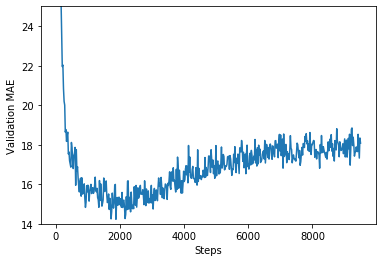

In [ ]:
import matplotlib.pyplot as plt
plt.plot(average_mae_history[:,0],average_mae_history[:,1])
plt.xlabel('Steps')
plt.ylabel('Validation MAE')
plt.ylim((14, 25))
plt.show()

Según esta gráfica, parece que el MAE deja de mejorar significativamente después de 150 epochs. Pasado ese punto, comenzamos a sobreajustar.

Una vez que hayamos terminado de ajustar otros parámetros de nuestro modelo (además del número de epochs, también podríamos ajustar el tamaño de las capas ocultas), podemos entrenar un modelo final con todos los datos de entrenamiento.

In [ ]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          nb_epoch=150, batch_size=16)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError
creating: createZooKerasMAE


In [ ]:
test_mae_score

1.6815447807312012

Nos desviamos unos $1.700.